Pump it Up: Data Mining the Water Table - Classification Rate: .8243

Cris Pineda and Diego Hernández Ronquillo

Load libraries:

In [24]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load the data:

In [25]:
watertrain = pd.read_csv("/Users/cris/Desktop/Courses/Second Semester/Machine Learning II/Assignment 2/watertrain.csv")
watertest = pd.read_csv("/Users/cris/Desktop/Courses/Second Semester/Machine Learning II/Assignment 2/watertest.csv")
target = pd.read_csv("/Users/cris/Desktop/Courses/Second Semester/Machine Learning II/Assignment 2/watertrainlab.csv")

Next, lets take a look at the shape and the distribution of the target variable.

training data shape:  (59400, 40) 
testing data shape:  (14850, 40)


,id,status_group
status_group,,
functional,32259,1
functional needs repair,4317,1
non functional,22824,1


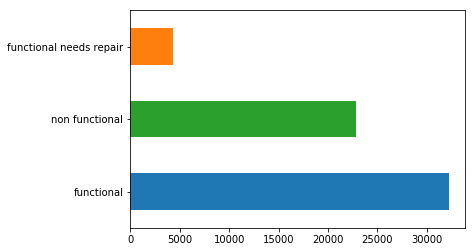

In [26]:
print("training data shape: ",watertrain.shape,"\ntesting data shape: ", watertest.shape)
palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]

# get counts for each 
target.status_group.value_counts().plot(kind='barh', color=palette)
target.groupby('status_group').nunique()

In [27]:
# take a quick look at the data
watertrain.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


DATA CLEANING

Checking for duplicates

In [28]:
print(len(np.unique(watertrain['id'])) == len(watertrain))
len(np.unique(watertest['id'])) == len(watertest)

# Check the length of the training set for reference
len(watertrain)

True


59400

In [29]:
# We can remove the id column and remember that the training set has 59,400 rows
watertrain_id = watertrain['id']
watertest_id = watertest['id']
target_id = target['id']

# drop id column
watertrain = watertrain.drop(['id'], axis=1)
watertest = watertest.drop(['id'], axis=1)
target = target.drop(['id'], axis=1)

# combine
waterfull = pd.concat([watertrain, watertest]).reset_index(drop=True)
waterfull.shape

(74250, 39)

In [30]:
# get an idea of what we are working with
waterfull.describe(include = ['O'])

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,70095,...,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,21,125,2098,2,...,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,...,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


Now, we will take a look at the null in the data frame.

In [31]:
# create a function to check nulls
def check_nulls(df):
    nulls = np.sum(df.isnull())
    nullcols = nulls.loc[(nulls != 0)]
    dtypes = df.dtypes
    dtypes2 = dtypes.loc[(nulls != 0)]
    info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
    print(info)
    print("There are", len(nullcols), "columns with missing values")
    
# use the function    
check_nulls(waterfull)  

                       0       1
scheme_name        35258  object
scheme_management   4846  object
installer           4532  object
funder              4504  object
public_meeting      4155  object
permit              3793  object
subvillage           470  object
There are 7 columns with missing values


Next, lets drop the unnecesary features. After playing around with different combinations, we finally decided to drop the following features which gave us the higher score.

In [32]:
# drop num_private since there is no documentation on it for now
waterfull = waterfull.drop(['num_private'], axis=1)

# drop scheme_name since there are more than half NaN and thousands of distinct variables
waterfull = waterfull.drop(['scheme_name'], axis=1)

# recorded_by has only one variable so we can get rid of
waterfull.recorded_by.nunique()
waterfull = waterfull.drop(['recorded_by'], axis=1)

# there are many columns where the group or type of it are just more broader categories of the same thing, so we remove
waterfull = waterfull.drop(['extraction_type_group'], axis=1)
waterfull = waterfull.drop(['extraction_type_class'], axis=1)
waterfull = waterfull.drop(['management_group'], axis=1)
waterfull = waterfull.drop(['payment_type'], axis=1)
waterfull = waterfull.drop(['quality_group'], axis=1)
waterfull = waterfull.drop(['quantity_group'], axis=1)
waterfull = waterfull.drop(['source_type'], axis=1)
waterfull = waterfull.drop(['source_class'], axis=1)
waterfull = waterfull.drop(['waterpoint_type_group'], axis=1)

In [33]:
# check nulls
check_nulls(waterfull) 

                      0       1
scheme_management  4846  object
installer          4532  object
funder             4504  object
public_meeting     4155  object
permit             3793  object
subvillage          470  object
There are 6 columns with missing values


Next, we imputed NaNs

In [34]:
# impute NA for now
waterfull['scheme_management'] = waterfull['scheme_management'].fillna(waterfull['scheme_management'].mode()[0])
waterfull['installer'] = waterfull['installer'].fillna('unknown')

# assume NaN is False
waterfull['public_meeting'] = waterfull['public_meeting'].fillna('False')

# turn 0 for construction_year to null then impute median
waterfull['construction_year'] = waterfull['construction_year'].replace(0,np.NaN)
waterfull['construction_year'] = waterfull.construction_year.fillna(waterfull['construction_year'].mean()) # better than the mode
waterfull['construction_year'] = waterfull['construction_year'].round()
waterfull['construction_year'] = waterfull['construction_year'].astype(int)

# for population since many have 0 and why would there be a water pump where no one lives
waterfull['population'] = waterfull['population'].replace(0,np.NaN)
waterfull['population'] = waterfull['population'].fillna(waterfull['population'].mode()[0]) # mode gets higher score
waterfull['population'] = waterfull['population'].round()

# permit fill with most used
waterfull['permit'] = waterfull['permit'].fillna(waterfull['permit'].mode()[0])


# for the second try
waterfull['subvillage'] = waterfull['subvillage'].fillna('unknown')
waterfull['funder'] = waterfull['funder'].fillna('unknown')

# check nulls again
check_nulls(waterfull)  

              0       1
installer  4532  object
There are 1 columns with missing values


Decided to parse the date_recorded feature to create some additional features.

In [35]:
import datetime

# Copied from MrBeer from GitHub
def date_parser(df):
    date_recorder = list(map(lambda x: datetime.datetime.strptime(str(x), '%Y-%m-%d'),
                             df['date_recorded'].values))
    df['year_recorder'] = list(map(lambda x: int(x.strftime('%Y')), date_recorder))
    df['weekday_recorder'] = list(map(lambda x: int(x.strftime('%w')), date_recorder))
    df['yearly_week_recorder'] = list(map(lambda x: int(x.strftime('%W')), date_recorder))
    df['month_recorder'] = list(map(lambda x: int(x.strftime('%m')), date_recorder))
    df['wpt_age'] = df['year_recorder'].values - df['construction_year'].values
    #del df['date_recorded']
    return df

date_parser(waterfull)

# drop since we don't need anymore
waterfull = waterfull.drop(['date_recorded'], axis=1) # keep construction_year

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,payment,water_quality,quantity,source,waterpoint_type,year_recorder,weekday_recorder,yearly_week_recorder,month_recorder,wpt_age
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322e+00,Lake Nyasa,Mnyusi B,Iringa,...,pay annually,soft,enough,spring,communal standpipe,2011,1,11,3,12
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466e+00,Lake Victoria,Nyamara,Mara,...,never pay,soft,insufficient,rainwater harvesting,communal standpipe,2013,3,9,3,3
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329e+00,Pangani,Majengo,Manyara,...,pay per bucket,soft,enough,dam,communal standpipe multiple,2013,1,8,2,4
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-1.115530e+01,Ruvuma / Southern Coast,Mahakamani,Mtwara,...,never pay,soft,dry,machine dbh,communal standpipe multiple,2013,1,4,1,27
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359e+00,Lake Victoria,Kyanyamisa,Kagera,...,never pay,soft,seasonal,rainwater harvesting,communal standpipe,2011,3,28,7,14
5,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587e+00,Pangani,Moa/Mwereme,Tanga,...,pay per bucket,salty,enough,other,communal standpipe multiple,2011,0,10,3,2
6,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365e+00,Internal,Ishinabulandi,Shinyanga,...,never pay,soft,enough,machine dbh,hand pump,2012,1,40,10,15
7,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198e+00,Lake Tanganyika,Nyawishi Center,Shinyanga,...,unknown,milky,enough,shallow well,hand pump,2012,2,41,10,15
8,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712e+00,Lake Tanganyika,Imalauduki,Tabora,...,never pay,salty,seasonal,machine dbh,hand pump,2012,6,44,11,15
9,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051e+00,Lake Victoria,Mkonomre,Kagera,...,never pay,soft,enough,shallow well,hand pump,2011,3,31,8,14


We had some outliers for longitude and latitude, so we will impute with the means of their respected regions.

In [ ]:
# view Long and Lat
watertrain['status_group'] = target
sns.lmplot(x='longitude', y='latitude', data=watertrain, fit_reg=False, 
           hue = 'status_group', scatter_kws={'alpha':0.2})

# we can see that we have some outliers

In [39]:
a = waterfull[waterfull["longitude"] < 1]
a.iloc[:,waterfull.columns == "latitude"]= np.nan
a.iloc[:,waterfull.columns == "longitude"]= np.nan
waterfull[waterfull["longitude"] < 1] = a
waterfull["longitude"] = waterfull.groupby("region_code").transform(lambda x: x.fillna(x.mean())).longitude
waterfull["latitude"] = waterfull.groupby("region_code").transform(lambda x: x.fillna(x.mean())).latitude


a= waterfull[waterfull["gps_height"] < 1]
a.iloc[:,waterfull.columns == "gps_height"]= np.nan
waterfull[waterfull["gps_height"] < 1] = a
waterfull["gps_height"] = waterfull.groupby("region_code").transform(lambda x: x.fillna(x.mean())).gps_height

waterfull=waterfull.fillna(waterfull.mean())

/Users/cris/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
# This was our original code, but the one above worked better so we will just leave it here for reference

# for longitude, we will replace value that is less than 29 with the mean
def replace_long(group):
    mean = group.mean()
    outliers = (group < 29)
    group[outliers] = mean 
    return group
waterfull['longitude'] = waterfull['longitude'].transform(replace_long)

# for latitude, we will replace all values that are greater than -0.9 with the mean
def replace_lat(group):
    mean = group.mean()
    outliers = (group > -0.9)
    group[outliers] = mean 
    return group
waterfull['latitude'] = waterfull['latitude'].transform(replace_lat)

/Users/cris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Both installer and funder features had over 2,000 distinct values, with many of them having mutliple features that were misspelled. We imputed a few that we errors but after doing a more in depth imputation, it made our score worse for some reason. So we will just leave the changes only to these below.

In [44]:
waterfull.installer.value_counts()

waterfull['installer'].replace('Gover', 'Government',inplace=True)
waterfull['installer'].replace('Commu', 'Community',inplace=True)
waterfull['installer'].replace('District council', 'District Council',inplace=True)
waterfull['installer'].replace('DW', 'DWE',inplace=True)
waterfull['installer'].replace('World vision', 'World Vision',inplace=True)
waterfull['installer'].replace('hesawa', 'HESAWA',inplace=True)
waterfull['installer'].replace('Central government', 'Government',inplace=True)
waterfull['installer'].replace('Gove', 'Government',inplace=True)
waterfull['installer'].replace('0','unknown',inplace=True)
waterfull['installer'].replace('Da', 'DANIDA',inplace=True)
waterfull['installer'].replace('DANID', 'DANIDA',inplace=True)
waterfull['installer'].replace('Hesawa', 'HESAWA',inplace=True)

In [46]:
waterfull.funder.value_counts()

waterfull['funder'].replace('Water', 'Ministry of Water',inplace=True)
waterfull['funder'].replace('Fini Water', 'Ministry of Water',inplace=True)
waterfull['funder'].replace('Water', 'Ministry of Water',inplace=True)
waterfull['funder'].replace('Government Of Tanzania', 'Government',inplace=True)
waterfull['funder'].replace('Germany Republi', 'Government',inplace=True)
waterfull['funder'].replace('Netherlands', 'Government',inplace=True)
waterfull['funder'].replace('0', 'unknown',inplace=True)
waterfull['funder'].replace('Netherlands', 'Government',inplace=True)
waterfull['funder'].replace('Ministry Of Water', 'Ministry of Water',inplace=True)
waterfull['funder'].replace('Private Individual', 'Private',inplace=True)

We also computed the frequence that each value for installer had, to give some extra features.

In [49]:
#Compute the frequency for each category instead of the name of the category
def col_freq(df, col_names):
    for col in col_names:
        print('Changing to frequency %s' % col)
        val_counts = df[col].value_counts()
        df[col + '_freq'] = np.zeros((df.shape[0],))
        for i, val in enumerate(df[col].values):
            df[col + '_freq'].iat[i] = int(val_counts.at[val])
    return df

waterfull = col_freq(waterfull, ['installer'])

Changing to frequency installer


Population is skewed, so we will transform it.

In [51]:
#Skew population as it has two dsitribution
waterfull.population = waterfull.population.apply(lambda x: np.log10(x+1))

Instead of creating dummy variables for each value, which would have led to over 70,000 features, we decided to use label encoding to transform all the object variables into numericals. 

In [52]:
from sklearn import preprocessing

# separate all the non numerical values
objects = []
for i in waterfull.columns:
    if waterfull[i].dtype == object or waterfull[i].dtype == bool:
        objects.append(i)

# apply LabelEncoder
for factor in objects:
    waterfull[factor] = preprocessing.LabelEncoder().fit_transform(waterfull[factor].astype(str))

# view
waterfull.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,region_code,...,water_quality,quantity,source,waterpoint_type,year_recorder,weekday_recorder,yearly_week_recorder,month_recorder,wpt_age,installer_freq
0,6000.0,1542,1390.0,1696,34.938093,-9.856322,1,13116,3,11,...,6,1,8,1,2011,1,11,3,12,119.0
1,0.0,518,1399.0,603,34.698766,-2.147466,4,17596,9,20,...,6,2,5,1,2013,3,9,3,3,50.0
2,25.0,920,686.0,2282,37.460664,-3.821329,5,10096,8,21,...,6,1,0,2,2013,1,8,2,4,843.0
3,0.0,1955,263.0,2068,38.486161,-11.155298,7,9998,12,90,...,6,0,3,2,2013,1,4,1,27,285.0
4,0.0,19,26.0,132,31.130847,-1.825359,4,8583,4,18,...,6,3,5,1,2011,3,28,7,14,169.0


Split the data to apply MinMax Scaler to help normalize the data since we are dealing with large amounts of different values for numerous features.

In [53]:
# split data frame
watertrain = waterfull.iloc[:59400,:]
watertest = waterfull.iloc[59400:,:]


print("train shape: ",watertrain.shape,"test shape: ",watertest.shape,"target shape: ",target.shape)

train shape:  (59400, 31) test shape:  (14850, 31) target shape:  (59400, 1)


In [54]:
from sklearn.preprocessing import MinMaxScaler

# convert to MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(watertrain)
train_scaled = scaler.transform(watertrain) 
test_scaled= scaler.transform(watertest)
train_scaled=pd.DataFrame(train_scaled)
test_scaled=pd.DataFrame(test_scaled)
train_scaled.columns = watertrain.columns 
test_scaled.columns = watertest.columns 
train = train_scaled
test = test_scaled

THE MODEL

After trying several models, we decided to stick with random forest classifier since it gave us the highest score for the competition and works well with our data set.

Also, we did not split the training data into training and testing, but instead used cross validation on the grid search to find the optimal parameters.

In [55]:
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_blobs
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score

PCA

We tried using PCA to reduce the dimensionality of a data set, but it was not effective. Here is the code for our attempt at it.

In [ ]:
#PCA to reduce the number of predictors in case there are correlated
pca = decomposition.PCA(n_components=32)
pca.fit(train)
train = pca.transform(train)

In [ ]:
# grid search for optimal parameters
from sklearn.model_selection import cross_val_score, GridSearchCV
grid = {
    "n_estimators": [500,1000], 
    "min_samples_split": [10],
    #"criterion": ['gini'],
    #"max_features": ["auto", len(factors)], 
    "bootstrap": [False], 
    "random_state": [69]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid = grid, cv = 3, verbose=2)
grid_search.fit(train, np.ravel(target))
optimal_model = grid_search.best_estimator_

print("Fine Tuned Model: {0}".format(optimal_model))

In [ ]:
# random forest model
model = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=69, verbose=0, warm_start=False)

model.fit(train, np.ravel(target))

XGBOOST

We also tried xgboost but it did not give us a higher score than using random forest.

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=500, learning_rate=0.001, n_jobs=20)
model.fit(train, target)

RANDOM FOREST - OUR MODEL

Random Forest Classifier was our optimal model for this competition. After trying both grid and random search, grid search gave us our best parameters. We applied a cross validation to ensure we were getting the best parameters. To reduce waiting time, we just stuck with the three most effective parameters for the model.

In [ ]:
# GRID SEARCH

rfc = RandomForestClassifier(n_jobs=10, max_features='sqrt', oob_score = True) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 18, 27, 32, 45, 54, 63],
           "max_depth" : [10, 50, 60, 70, 100, 150, 200, 350, 500],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 10)
CV_rfc.fit(train, target)
print(CV_rfc.best_params_)

In [59]:
# random forest with grid search parameters
rfc = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=69, verbose=0, warm_start=False)
rfc.fit(train, np.ravel(target))

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=69, verbose=0, warm_start=False)

In [60]:
predictions = rfc.predict(test)

# submission
submission = pd.DataFrame(predictions, columns=['status_group'])
submission.insert(0, 'id', watertest_id)
submission.reset_index()
submission.to_csv('submission.csv', index = False)

Our score for the Pump It Water: Data Mining the Water Table was a .8243, which (as of 30/03/2018) put us at rank 77 out of 4649 competitors, top 1.6%!
    
One key takeaway is that a lot of the things that we thought should have made our score better, such as fixing the errors in installer and funder features, did not work. Even keeping the waterpoint name feature, which should be irrelevant to the condition of the water pump, made our score better.